/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_

RMSE: 6.2433928833753525
MAE: 6.230135396378752
MAPE: 270.8863798024612%
R-squared: -19.121902578521446


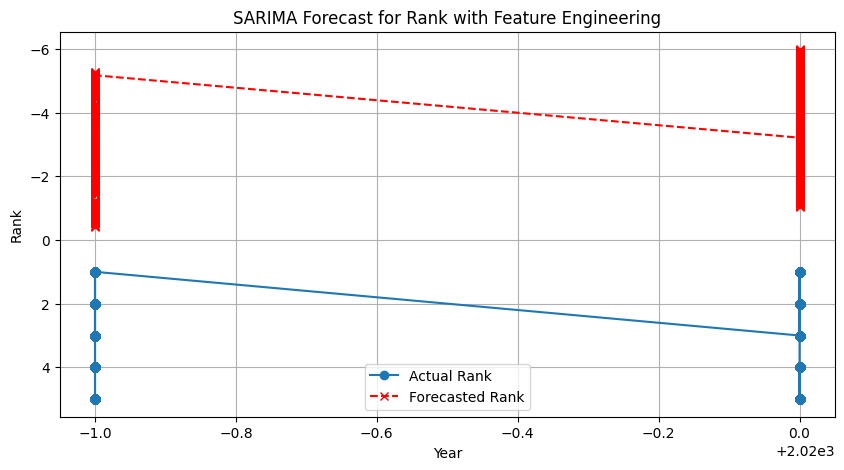

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

# Load dataset
df = pd.read_csv("/content/trends.csv")

# Select relevant features (ensure all are numeric)
df_filtered = df[["year", "rank", "query"]].copy()  # Use actual numeric columns

# Convert categorical "query" column into numeric (Ordinal Encoding)
label_encoder = LabelEncoder()
df_filtered["query"] = label_encoder.fit_transform(df_filtered["query"])

# Ensure data is sorted by year
df_filtered = df_filtered.sort_values(by="year").drop_duplicates()

# Feature Engineering - Create lag features for 'rank' and 'query'
df_filtered['rank_lag1'] = df_filtered['rank'].shift(1)
df_filtered['rank_lag2'] = df_filtered['rank'].shift(2)
df_filtered['rank_lag3'] = df_filtered['rank'].shift(3)

# Create rolling mean and rolling standard deviation as additional features
df_filtered['rank_rollmean'] = df_filtered['rank'].rolling(window=3).mean()
df_filtered['rank_rollstd'] = df_filtered['rank'].rolling(window=3).std()

# Drop rows with NaN values (created due to lag features)
df_filtered = df_filtered.dropna()

# Split into train and test
train_size = int(len(df_filtered) * 0.8)
train, test = df_filtered.iloc[:train_size], df_filtered.iloc[train_size:]

# Check stationarity using Augmented Dickey-Fuller test
def check_stationarity(series):
    result = adfuller(series.dropna())  # Drop NaN before testing
    return result[1]  # Return p-value

p_value = check_stationarity(df_filtered['rank'])
if p_value > 0.05:
    df_filtered['rank'] = df_filtered['rank'].diff().dropna()  # Differencing if needed

# Fit SARIMA model
sarima_model = SARIMAX(train['rank'],
                      exog=train[['rank_lag1', 'rank_lag2', 'rank_lag3', 'rank_rollmean', 'rank_rollstd']],  # Add engineered features
                      order=(1, 1, 1),  # p, d, q (You can fine-tune these)
                      seasonal_order=(1, 1, 1, 12),  # Seasonal parameters (12 for yearly seasonality, can be adjusted)
                      enforce_stationarity=False,
                      enforce_invertibility=False)

# Train the model
sarima_result = sarima_model.fit(disp=False)

# Forecast the future
forecast_steps = len(test)
forecast = sarima_result.predict(start=len(train), end=len(train) + forecast_steps - 1,
                                  exog=test[['rank_lag1', 'rank_lag2', 'rank_lag3', 'rank_rollmean', 'rank_rollstd']])

# Evaluate Model Performance with multiple metrics
rmse = np.sqrt(mean_squared_error(test['rank'], forecast))
mae = mean_absolute_error(test['rank'], forecast)
mape = mean_absolute_percentage_error(test['rank'], forecast) * 100  # In percentage
r2 = r2_score(test['rank'], forecast)

# Print evaluation metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")
print(f"R-squared: {r2}")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(test['year'], test['rank'], label="Actual Rank", marker="o")
plt.plot(test['year'], forecast, label="Forecasted Rank", linestyle="dashed", marker="x", color="red")
plt.legend()
plt.title("SARIMA Forecast for Rank with Feature Engineering")
plt.xlabel("Year")
plt.ylabel("Rank")
plt.gca().invert_yaxis()  # Assuming lower rank is better
plt.grid()
plt.show()
